In [17]:
env = gym.make("CartPole-v1", render_mode="human")  
env

<TimeLimit<OrderEnforcing<PassiveEnvChecker<CartPoleEnv<CartPole-v1>>>>>

In [19]:
import torch.nn as nn
import torch
import torch.optim as optim
import torch.nn.functional as F 



class Qnetwork(nn.Module):
    def __init__(self,state_size,action_size):
        super(Qnetwork,self).__init__()

        self.fc1=nn.Linear(state_size,128)
        self.fc2=nn.Linear(128,128)
        self.fc3=nn.Linear(128,action_size)

    def forward(self,state):

        x=torch.relu(self.fc1(torch.tensor(state)))
        x=torch.relu(self.fc2(x))
        return self.fc3(x)

target_network=Qnetwork(4,2)
online_network=Qnetwork(4,2)

In [20]:
import math
import random

class Pendulo:
    def __init__(self,env):
        self.env= env
    
    def get_action(self,q_values,step,start,end,decay):
        epsilon=(end+(start-end)*math.exp(-step/decay))
        sample=random.randint(0,2)
        if sample<epsilon:
            return random.choice(range(len(q_values)))
    
        return torch.argmax(q_values).item()
    

    def reset(self):
        self.env.reset()
     



In [21]:
from collections import deque
import numpy as np
import torch

class ReplayBuffer:

    def __init__(self,capacity):

        self.memory=deque(maxlen=capacity)
    
    def push(self,state,action,reward,next_state,done):

        experience_tuple=(state,action,reward,next_state,done)
        self.memory.append(experience_tuple)

    def __len__(self):
        return  len(self.memory)
    
    def sample(self,batch_size):

        batch=random.sample(self.memory,batch_size)

        states,actions,rewards,next_states,dones=zip(*batch)
        
        states=torch.tensor(states,dtype=torch.float32)
        actions=torch.tensor(actions,dtype=torch.long).unsqueeze(1)
        rewards=torch.tensor(rewards,dtype=torch.float32)
        next_states=torch.tensor(next_states,dtype=torch.float32)
        dones=torch.tensor(dones,dtype=torch.float32)

        return(states,actions,rewards,next_states,dones)
    

In [22]:
def update_target_network(target_network,online_network,tau):
    target_net_state_dict=target_network.state_dict()
    online_net_state_dict=online_network.state_dict()

    for key in online_net_state_dict:
        target_net_state_dict[key]=(online_net_state_dict[key]*tau+target_net_state_dict[key]*(1-tau))

        target_network.load_state_dict(target_net_state_dict)
        
    return done



In [23]:
def set_seed(env, seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    env.reset(seed=seed)
    env.action_space.seed(seed)
    env.observation_space.seed(seed)

In [24]:
replay_buffer=ReplayBuffer(50000)
tau=0.005
gamma=0.99
batch_size=64
optimizer=optim.Adam(online_network.parameters(),lr=5e-5)
pendulo=Pendulo(env)
set_seed(env, seed=42)


In [25]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [26]:

reward_lis=[]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
for episode in range(1000):

    state,info=env.reset()
    done=False
    step=0
    episode_reward=0

    while not done:
        step+=1
        q_values=online_network(state)
        action=pendulo.get_action(q_values,step,start=0.9,end=0.05,decay=1000)
        next_state,reward,terminate,truncated,_=env.step(action)
        done=terminate or truncated
        replay_buffer.push(state,action,reward,next_state,done)

        if len(replay_buffer)>=batch_size:

            states,actions,rewards,nex_states,dones=replay_buffer.sample(64)
            q_values=online_network(states).gather(1,actions).squeeze(1)
            with torch.no_grad():
                next_actions=online_network(nex_states).argmax(1).unsqueeze(1)
                next_q_values=target_network(nex_states).gather(1,next_actions).squeeze(1)
                target_q_values=rewards+gamma*next_q_values*(1-dones)

            loss=F.mse_loss(q_values, target_q_values)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            update_target_network(target_network,online_network,tau)
        
        state=next_state
        episode_reward+=reward
    reward_lis.append(episode_reward)
    
    print(f"Episode: {episode}, Step: {step}, Reward: {reward}, Total Reward: {episode_reward}")

    

Episode: 0, Step: 9, Reward: 1.0, Total Reward: 9.0
Episode: 1, Step: 15, Reward: 1.0, Total Reward: 15.0
Episode: 2, Step: 13, Reward: 1.0, Total Reward: 13.0
Episode: 3, Step: 9, Reward: 1.0, Total Reward: 9.0
Episode: 4, Step: 11, Reward: 1.0, Total Reward: 11.0


C:\Users\edgar\AppData\Local\Temp\ipykernel_28980\997204895.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x=torch.relu(self.fc1(torch.tensor(state)))


Episode: 5, Step: 10, Reward: 1.0, Total Reward: 10.0
Episode: 6, Step: 10, Reward: 1.0, Total Reward: 10.0
Episode: 7, Step: 16, Reward: 1.0, Total Reward: 16.0
Episode: 8, Step: 11, Reward: 1.0, Total Reward: 11.0
Episode: 9, Step: 9, Reward: 1.0, Total Reward: 9.0
Episode: 10, Step: 10, Reward: 1.0, Total Reward: 10.0
Episode: 11, Step: 10, Reward: 1.0, Total Reward: 10.0
Episode: 12, Step: 9, Reward: 1.0, Total Reward: 9.0
Episode: 13, Step: 10, Reward: 1.0, Total Reward: 10.0
Episode: 14, Step: 9, Reward: 1.0, Total Reward: 9.0
Episode: 15, Step: 13, Reward: 1.0, Total Reward: 13.0
Episode: 16, Step: 12, Reward: 1.0, Total Reward: 12.0
Episode: 17, Step: 13, Reward: 1.0, Total Reward: 13.0
Episode: 18, Step: 11, Reward: 1.0, Total Reward: 11.0
Episode: 19, Step: 9, Reward: 1.0, Total Reward: 9.0
Episode: 20, Step: 10, Reward: 1.0, Total Reward: 10.0
Episode: 21, Step: 11, Reward: 1.0, Total Reward: 11.0
Episode: 22, Step: 10, Reward: 1.0, Total Reward: 10.0
Episode: 23, Step: 20, 

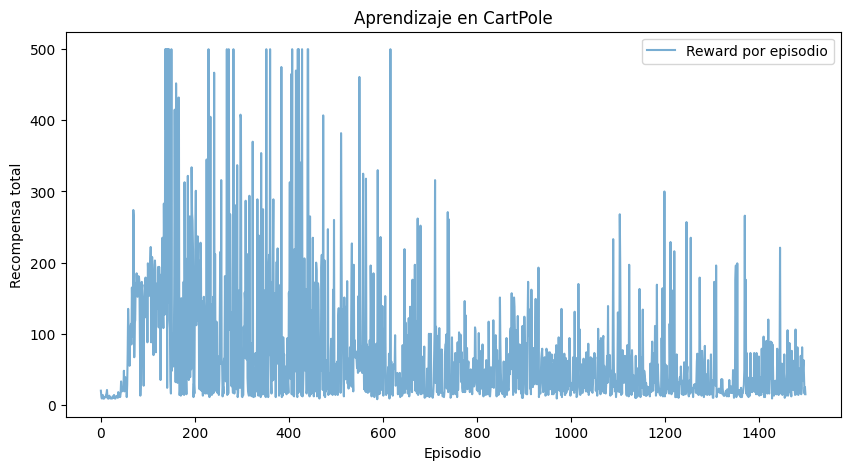

In [ ]:

import matplotlib.pyplot as plt

#Promedio móvil (rolling mean)
#window = 100
#moving_avg = np.convolve(reward_lis, np.ones(window)/window, mode="valid")

plt.figure(figsize=(10,5))
plt.plot(reward_lis, label="Reward por episodio", alpha=0.6)
#plt.plot(range(window-1, len(reward_lis)), moving_avg, label=f"Promedio móvil {window}", linewidth=2, color="red")
plt.xlabel("Episodio")
plt.ylabel("Recompensa total")
plt.title("Aprendizaje en CartPole")
plt.legend()
plt.show()



"""

replay_buffer=ReplayBuffer(10000)
tau=0.01
gamma=0.99
batch_size=64
optimizer=optim.Adam(online_network.parameters(),lr=1e-4)
pendulo=Pendulo(env)
set_seed(env, seed=42)


"""

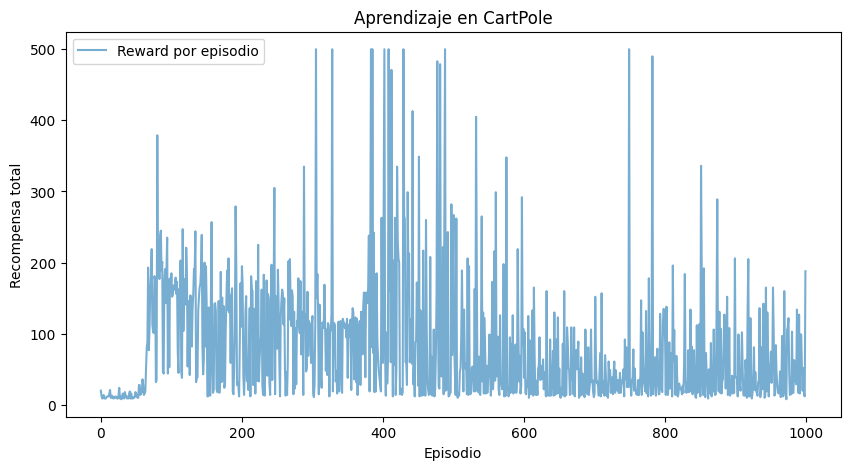

In [ ]:
import matplotlib.pyplot as plt

#Promedio móvil (rolling mean)
#window = 100
#moving_avg = np.convolve(reward_lis, np.ones(window)/window, mode="valid")

plt.figure(figsize=(10,5))
plt.plot(reward_lis, label="Reward por episodio", alpha=0.6)
#plt.plot(range(window-1, len(reward_lis)), moving_avg, label=f"Promedio móvil {window}", linewidth=2, color="red")
plt.xlabel("Episodio")
plt.ylabel("Recompensa total")
plt.title("Aprendizaje en CartPole")
plt.legend()
plt.show()



"""

replay_buffer=ReplayBuffer(50000)
tau=0.005
gamma=0.99
batch_size=64
optimizer=optim.Adam(online_network.parameters(),lr=1e-4)
pendulo=Pendulo(env)
set_seed(env, seed=42)


"""

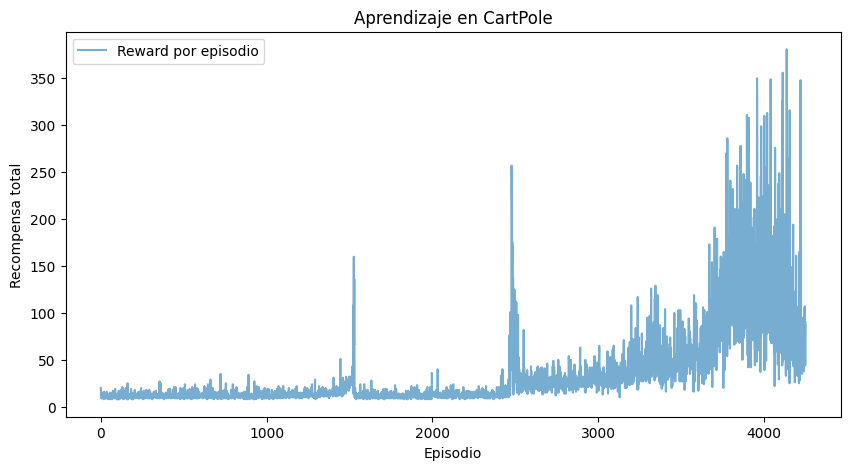

'\nneuronas de 64\nreplay_buffer=ReplayBuffer(50000)\ntau=0.005\ngamma=0.99\nbatch_size=64\noptimizer=optim.Adam(online_network.parameters(),lr=1e-5)\npendulo=Pendulo(env)\nset_seed(env, seed=42)\n\n\n'

In [153]:
import matplotlib.pyplot as plt

#Promedio móvil (rolling mean)
#window = 100
#moving_avg = np.convolve(reward_lis, np.ones(window)/window, mode="valid")

plt.figure(figsize=(10,5))
plt.plot(reward_lis, label="Reward por episodio", alpha=0.6)
#plt.plot(range(window-1, len(reward_lis)), moving_avg, label=f"Promedio móvil {window}", linewidth=2, color="red")
plt.xlabel("Episodio")
plt.ylabel("Recompensa total")
plt.title("Aprendizaje en CartPole")
plt.legend()
plt.show()


"""
neuronas de 64
replay_buffer=ReplayBuffer(50000)
tau=0.005
gamma=0.99
batch_size=64
optimizer=optim.Adam(online_network.parameters(),lr=1e-5)
pendulo=Pendulo(env)
set_seed(env, seed=42)


"""

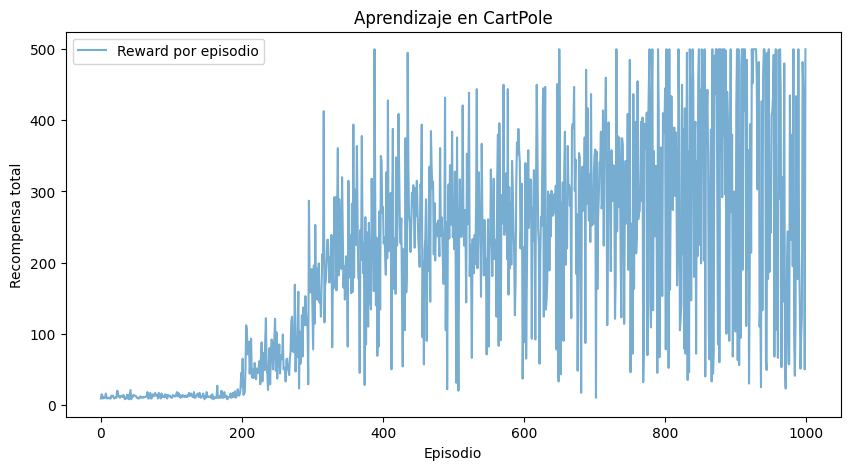

'\n\nreplay_buffer=ReplayBuffer(50000)\ntau=0.005\ngamma=0.99\nbatch_size=64\noptimizer=optim.Adam(online_network.parameters(),lr=5e-5)\npendulo=Pendulo(env)\nset_seed(env, seed=42)\n\n\n'

In [27]:
import matplotlib.pyplot as plt

#Promedio móvil (rolling mean)
#window = 100
#moving_avg = np.convolve(reward_lis, np.ones(window)/window, mode="valid")

plt.figure(figsize=(10,5))
plt.plot(reward_lis, label="Reward por episodio", alpha=0.6)
#plt.plot(range(window-1, len(reward_lis)), moving_avg, label=f"Promedio móvil {window}", linewidth=2, color="red")
plt.xlabel("Episodio")
plt.ylabel("Recompensa total")
plt.title("Aprendizaje en CartPole")
plt.legend()
plt.show()


"""

replay_buffer=ReplayBuffer(50000)
tau=0.005
gamma=0.99
batch_size=64
optimizer=optim.Adam(online_network.parameters(),lr=5e-5)
pendulo=Pendulo(env)
set_seed(env, seed=42)


"""

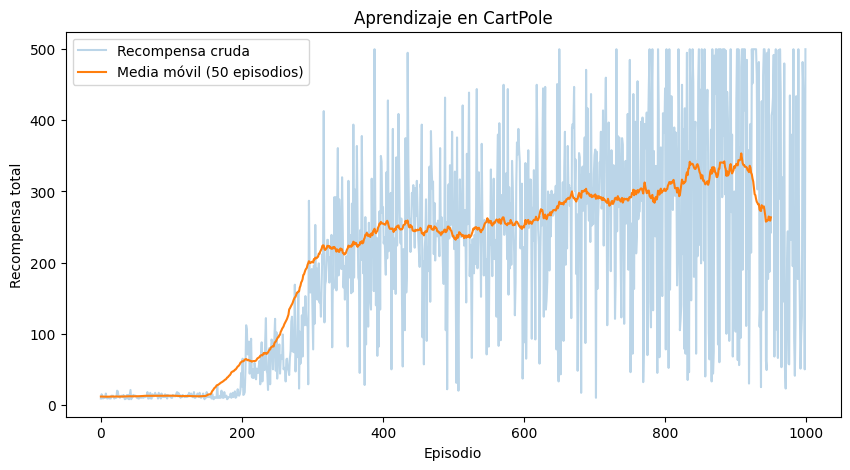

In [28]:
import numpy as np
import matplotlib.pyplot as plt

def moving_average(data, window_size=50):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

plt.figure(figsize=(10,5))
plt.plot(reward_lis, alpha=0.3, label="Recompensa cruda")
plt.plot(moving_average(reward_lis, 50), label="Media móvil (50 episodios)")
plt.xlabel("Episodio")
plt.ylabel("Recompensa total")
plt.title("Aprendizaje en CartPole")
plt.legend()
plt.show()

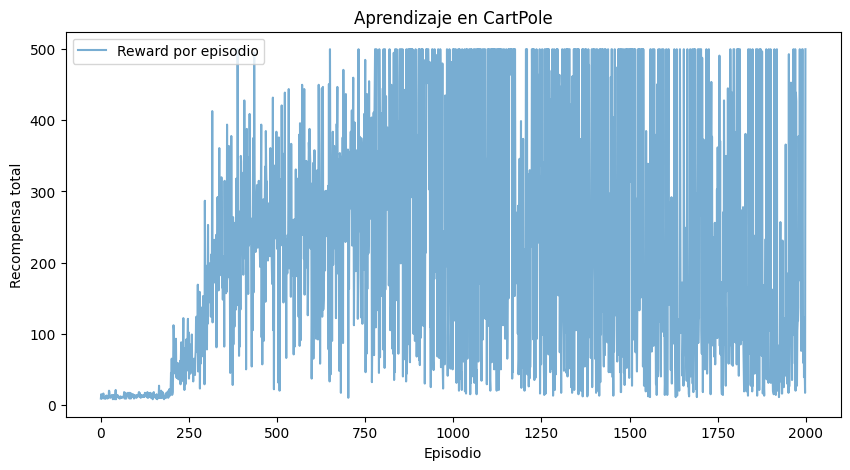

'\n\nreplay_buffer=ReplayBuffer(50000)\ntau=0.005\ngamma=0.99\nbatch_size=64\noptimizer=optim.Adam(online_network.parameters(),lr=1e-4)\npendulo=Pendulo(env)\nset_seed(env, seed=42)\n\n'

In [ ]:
import matplotlib.pyplot as plt

#Promedio móvil (rolling mean)
#window = 100
#moving_avg = np.convolve(reward_lis, np.ones(window)/window, mode="valid")

plt.figure(figsize=(10,5))
plt.plot(reward_lis, label="Reward por episodio", alpha=0.6)
#plt.plot(range(window-1, len(reward_lis)), moving_avg, label=f"Promedio móvil {window}", linewidth=2, color="red")
plt.xlabel("Episodio")
plt.ylabel("Recompensa total")
plt.title("Aprendizaje en CartPole")
plt.legend()
plt.show()



"""

replay_buffer=ReplayBuffer(50000)
tau=0.005
gamma=0.99
batch_size=128
optimizer=optim.Adam(online_network.parameters(),lr=5e-5)
pendulo=Pendulo(env)
set_seed(env, seed=42)

"""

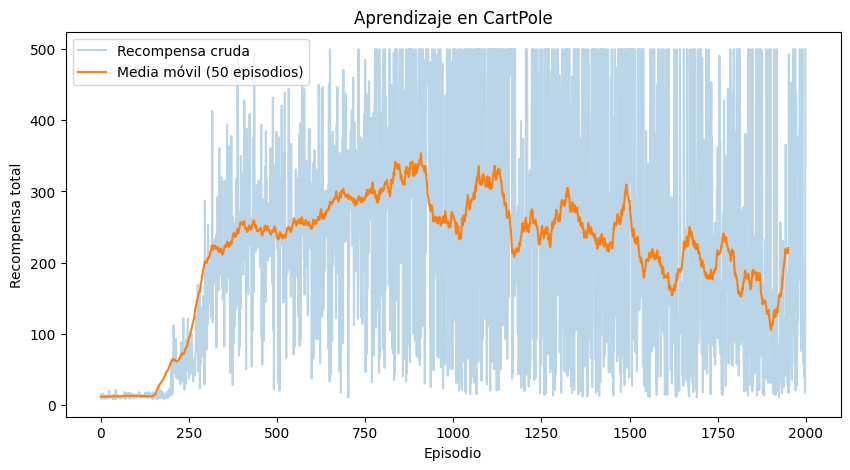

In [176]:
import numpy as np
import matplotlib.pyplot as plt

def moving_average(data, window_size=50):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

plt.figure(figsize=(10,5))
plt.plot(reward_lis, alpha=0.3, label="Recompensa cruda")
plt.plot(moving_average(reward_lis, 50), label="Media móvil (50 episodios)")
plt.xlabel("Episodio")
plt.ylabel("Recompensa total")
plt.title("Aprendizaje en CartPole")
plt.legend()
plt.show()

In [ ]:

checkpoint = {
    "online_network": online_network.state_dict(),
    "target_network": target_network.state_dict(),
}
torch.save(checkpoint, "ddqn_cartpole.pth")


In [30]:

online_network.load_state_dict(checkpoint["online_network"])
target_network.load_state_dict(checkpoint["target_network"])

<All keys matched successfully>

In [61]:
completados=0
total_rewards=[]
for episode in range(100):

    state,info=env.reset()
    done=False
    step=0


    while not done:

        with torch.no_grad():
            step+=1
            q_values=online_network(state)
            action = torch.argmax(q_values).item()
            next_state,reward,terminate,truncated,_=env.step(action)
            done=terminate or truncated

        total_rewards.append(rewards)
        state=next_state

       
        if step==500:
            completados+=1
            print(f"Episodio {episode+1} completado--- completados: {completados}")


Episodio 1 completado--- completados: 1
Episodio 2 completado--- completados: 2
Episodio 3 completado--- completados: 3
Episodio 4 completado--- completados: 4
Episodio 5 completado--- completados: 5
Episodio 6 completado--- completados: 6
Episodio 7 completado--- completados: 7
Episodio 8 completado--- completados: 8
Episodio 9 completado--- completados: 9
Episodio 10 completado--- completados: 10
Episodio 11 completado--- completados: 11
Episodio 12 completado--- completados: 12
Episodio 13 completado--- completados: 13
Episodio 14 completado--- completados: 14
Episodio 15 completado--- completados: 15
Episodio 16 completado--- completados: 16
Episodio 17 completado--- completados: 17
Episodio 18 completado--- completados: 18
Episodio 19 completado--- completados: 19
Episodio 20 completado--- completados: 20
Episodio 21 completado--- completados: 21
Episodio 22 completado--- completados: 22
Episodio 23 completado--- completados: 23
Episodio 24 completado--- completados: 24
Episodio 2

In [ ]:
accuracy=completados/100*100
print(f'{accuracy} %')

98.0 %


: 